### Simulation model of EMT with multiple semi-stable attractors (E, M, H)

**Imports**

In [1]:
%load_ext nb_black
import nodescape as n

odeint, torch, np, pd, plt, nn, a, os, time, optim, sp, PCA, v = n.dev.load_dev_libs()

<IPython.core.display.Javascript object>

### Published simulation of EMT

The published simulation models a slow "pulse" of i2 (which triggers SNAI1 production). The "basal" level of such molecules is set to 50k molecules/hr.

Dongya created a template simulation of an instance of EMT, which exhibits tri-stability. We'll recreate this simulation and create multiple trajectories with noise and varying starting points based on a distribution of initial conditions. The ultimate goal is to understand this EMT model through the lens of *neural ODEs*.

In [2]:
emt_time_ = pd.read_csv("./EMT_simulation/EMT_timecourse_data.csv")
print("Shape: ", emt_time_.shape)
emt_time_.head()

Shape:  (7201, 6)


,Time (h),miR-200,ZEB mRNA,miR-34,SNAIL mRNA,Signal driving SNAIL
0,0.000000,37181.88000,3.520000,35092.82000,17.540000,0.000000
1,0.041667,37386.38398,7.142674,34632.61809,71.252057,27.777778
2,0.083333,37541.97536,8.887348,34146.83638,96.923834,55.555556
3,0.125000,37663.82739,9.898738,33662.67174,109.476914,83.333333
4,0.166667,37764.59876,10.480006,33191.22405,115.769004,111.111111


<IPython.core.display.Javascript object>

Let's create an AnnData object for further use. 

In [3]:
adata = n.utils.read_csv(
    "./EMT_simulation/EMT_timecourse_data.csv",
    usecols=[0, 1, 2, 3, 4, 5],
    names=["time", "miR200", "mZ", "miR34", "mS", "i2"],
)

AnnData object with n_obs × n_vars = 7201 × 4
    obs: 'time', 'i2', 'all_data'


<IPython.core.display.Javascript object>

AnnData object with n_obs × n_vars = 7201 × 4
    obs: 'time', 'i2', 'all_data'
    obsm: 'X_pca'


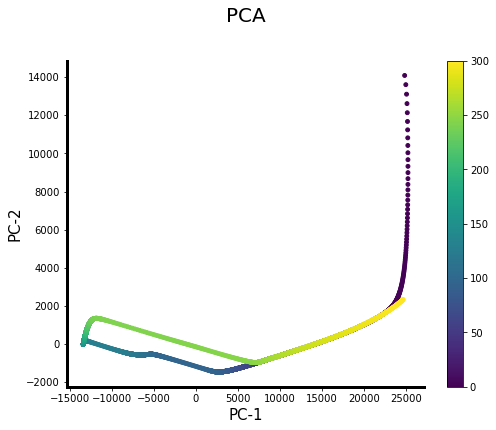

<IPython.core.display.Javascript object>

In [4]:
n.utils.pca(adata, plot=True)

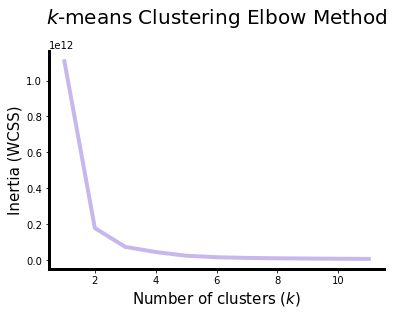

<IPython.core.display.Javascript object>

In [5]:
n.math.get_kmeans_inertia(adata.obsm["X_pca"], k_max=12)

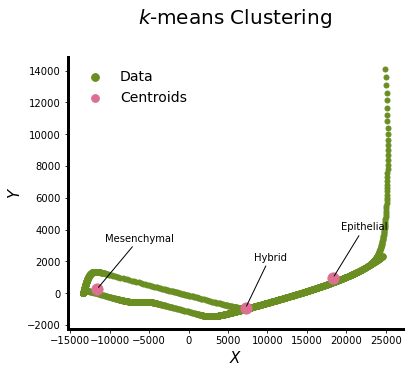

<IPython.core.display.Javascript object>

In [6]:
n.math.kmeans(
    adata.obsm["X_pca"], k=3, annotations=["Hybrid", "Mesenchymal", "Epithelial"]
)

#### Characterize cell states for Epithelial (**E**), Mesenchymal (**M**) and the semi-stable hybrid state (**H**).

The optimtal starting points can be found from realistic conditions that have been generated from initial conditions, which reach each state.

In [7]:
path_reaching_epithelial = "./EMT_simulation/reaching_epithelial.csv"
path_reaching_mesenchymal = "./EMT_simulation/reaching_mesenchymal.csv"
path_reaching_hybrid = "./EMT_simulation/reaching_hybrid.csv"

colnames = ["time", "miR200", "mZEB", "miR34", "mSNAIL", "i2"]

reaching_epithelial = pd.read_csv(
    path_reaching_epithelial, header=None, names=colnames, skiprows=1
)
reaching_mesenchymal = pd.read_csv(
    path_reaching_mesenchymal, header=None, names=colnames, skiprows=1
)
reaching_hybrid = pd.read_csv(
    path_reaching_hybrid, header=None, names=colnames, skiprows=1
)

<IPython.core.display.Javascript object>

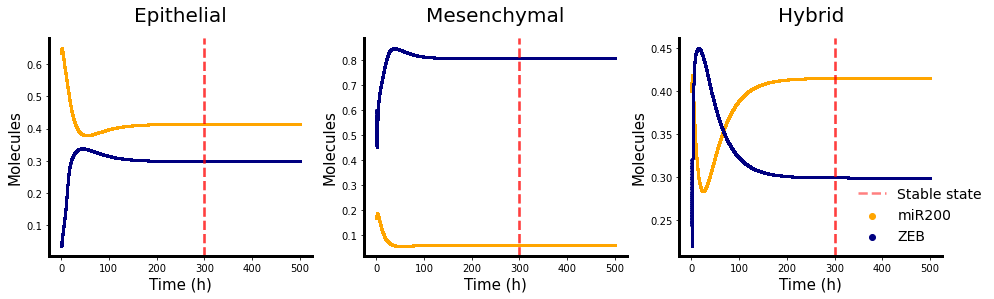

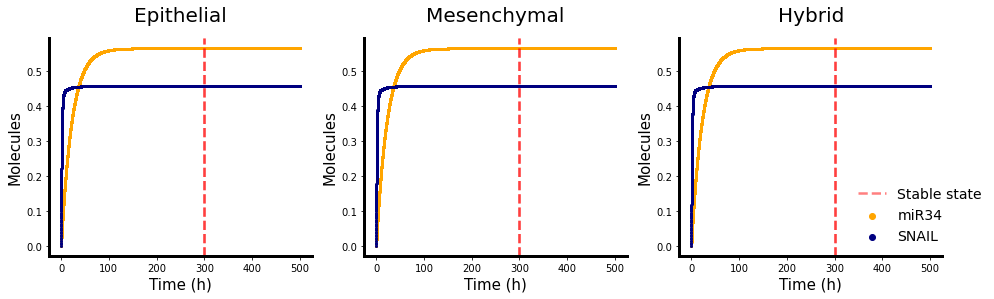

<IPython.core.display.Javascript object>

In [8]:
n.sim.EMT.plot_EMH(
    reaching_epithelial, reaching_mesenchymal, reaching_hybrid, mode="ZEB/miR200"
)
n.sim.EMT.plot_EMH(
    reaching_epithelial, reaching_mesenchymal, reaching_hybrid, mode="SNAIL/miR34"
)

We're going to take the value at `t = 300 h` (dotted red line) since this represents a "stable" state for each of the processes. The initial conditions at each of these will serve as the mean for the initial conditions we sample. The values are scaled for nice plotting here, however I will be taking the original values, to start. When we perform PCA, we'll have to scale accordingly, but we'll cross that bridge when we come to it.

In [9]:
epi_ss = n.sim.EMT.get_ss(reaching_epithelial, 300)[:, np.newaxis]
mes_ss = n.sim.EMT.get_ss(reaching_mesenchymal, 300)[:, np.newaxis]
hyb_ss = n.sim.EMT.get_ss(reaching_hybrid, 300)[:, np.newaxis]

<IPython.core.display.Javascript object>

Now let's use these steady state values as the mean for a gaussian sampling of values for initial conditions. For now, we'll create 20 trajectories for each. 

In [10]:
epi_trajs = n.sim.generate_initial_conditions(50, epi_ss, variance=500)
mes_trajs = n.sim.generate_initial_conditions(50, mes_ss, variance=500)
hyb_trajs = n.sim.generate_initial_conditions(50, hyb_ss, variance=500)

combined_conditions = np.vstack([epi_trajs, mes_trajs, hyb_trajs])
cols = "time", "miR200", "mZEB", "miR34", "mSNAIL", "i2"

<IPython.core.display.Javascript object>

### Create more trajectories from the same simulation

**Set the parameters**

The parameters for the EMT simulation are pre-set from published specifications. However, we can add noise to these values through the variable, `variance` in the `n.sim.EMT.simulate` function. Additionally, initial conditions, which were extracted above are used as starting points (red lines at `t=300`).

0 rows eliminated at line []
AnnData object with n_obs × n_vars = 1080000 × 4
    obs: 'time', 'i2', 'trajectory'
    uns: 'number_of_trajectories'
    obsm: 'X_pca'


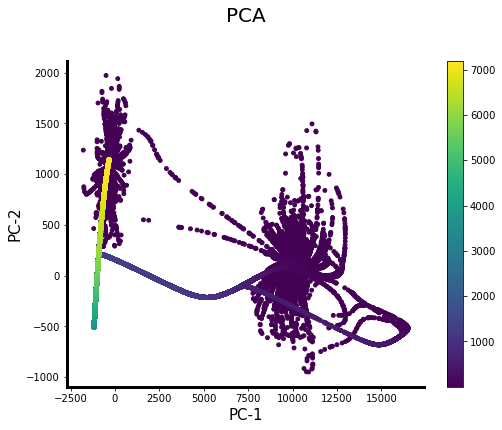

<IPython.core.display.Javascript object>

In [11]:
adata = n.sim.EMT.simulate(combined_conditions, cols, parameter_variance=None)
n.utils.pca(adata, plot=True)

AnnData object with n_obs × n_vars = 1080000 × 4
    obs: 'time', 'i2', 'trajectory'
    uns: 'number_of_trajectories'
    obsm: 'X_pca'


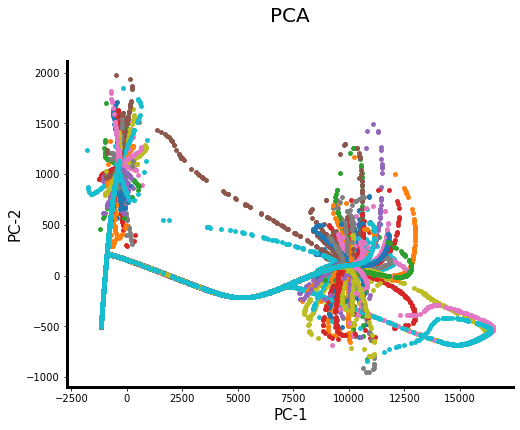

<IPython.core.display.Javascript object>

In [12]:
n.utils.pca(adata, plot=True, colorby="trajectory")

Interestingly, we can see pools that may represent attractor states when dictated by density.

### Train neural ODEs on the dataset

**Prepare data for neural ODEs**:

We need to split data into `training`, `validation`, and `test` groups. The following function does so **by trajectory**, meaning whole trajectories are grouped, rather than individual points. 

In [13]:
prepared_data = n.ml.split_test_train(adata, return_data_subsets=True)

<IPython.core.display.Javascript object>

In [14]:
n.utils.write_processed(prepared_data, "EMT_simulation", adata, include_adata=True)

Processed data written.
AnnData written.


<IPython.core.display.Javascript object>

---
#### Killed notebook. Reading processed data:

In [15]:
import nodescape as n

odeint, torch, np, pd, plt, nn, a, os, time, optim, sp, PCA, v = n.dev.load_dev_libs()

prepared_data = n.utils.read_processed("./EMT_simulation/EMT_simulation.zip")
adata = a.read_h5ad("./EMT_simulation/EMT_simulation.h5ad")

<IPython.core.display.Javascript object>